In [1]:
# Install required package
import sys
# !{sys.executable} -m pip install --user steam-nb-api

import os
import csv
from pathlib import Path
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.lines as lines

from copy import *
from steam_nb_api.ledet.ParametersLEDET import ParametersLEDET
from steam_nb_api.utils import misc
from steam_nb_api.roxie_parser import MagneticCoil
from steam_nb_api.utils.SelfMutualInductanceCalculation import SelfMutualInductanceCalculation

from steam_nb_api.roxie_parser import CableDatabase
from steam_nb_api.roxie_parser import ConductorPosition
from steam_nb_api.roxie_parser.geometricFunctions import close_pairs_ckdtree, close_pairs_pdist

# Global variables

In [2]:
nameMagnet = 'MU'

# Define style for plots
selectedFont = {'fontname':'DejaVu Sans', 'size':14}

# If this variable is set to True, many comments will be displayed
verbose = False

# Load default LEDET variable descriptions
paramLEDET_notebook = ParametersLEDET()

# Generate magnet geometry parsing .data and .cadata files

In [3]:
# Select ROXIE .cadata file with conductor data
currentDirectory = Path(os.path.split(os.getcwd())[0])
fileNameCadata = os.path.join(currentDirectory,'resources','roxie.cadata')
fileName = nameMagnet + '_All_WithIron_WithSelfField.map2d'
fileNameData = nameMagnet + '_All_WithIron_WithSelfField.data'

print(fileNameData)
    
# Define the magnetic coil
definedMagneticCoil = MagneticCoil.MagneticCoil()
xPos, yPos, iPos, xBarePos, yBarePos, xS, yS, iS = definedMagneticCoil.generateCoilGeometry(fileNameData, fileNameCadata, verbose=verbose)
# Plot conductors and their numbers
f = plt.figure(2, figsize=(10, 10))
# Plot edges
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r', edgecolor='k', alpha=.25)
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='b', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)

    # Plot conductor numbers
    x_ave_cond, y_ave_cond = sum(cXPos) / len(cXPos), sum(cYPos) / len(cYPos)
    plt.text(x_ave_cond, y_ave_cond, '{}'.format(c + 1))

# Plot edges of bare conductors
for c, (cXBarePos, cYBarePos) in enumerate(zip(xBarePos, yBarePos)):
    pt1, pt2, pt3, pt4 = (cXBarePos[0], cYBarePos[0]), (cXBarePos[1], cYBarePos[1]), (cXBarePos[2], cYBarePos[2]), (
    cXBarePos[3], cYBarePos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=False, facecolor='r', edgecolor='k', alpha=.25)
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=False, facecolor='b', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)

plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Conductors and their numbers', **selectedFont)
plt.set_cmap('jet')
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.grid()

MU_All_WithIron_WithSelfField.data



<IPython.core.display.Javascript object>

In [4]:
RibbonCable = True
# Array, that defines each group--> [No. of Layers, Ribbons per Group]
GeoArr = [[34,26]]*16

if RibbonCable:
    # Read file
    newFileName = nameMagnet + '_ROXIE_All_WithIron_WithSelfField.map2d'
    if not os.path.isfile(newFileName):
        os.rename(fileName, newFileName)
    file = open(newFileName, "r")
    fileContent = file.read()

    # Separate rows
    fileContentByRow = fileContent.split("\n")
    NewMap2d = np.array([[ None for x in range(10)] 
                 for y in range(2,len(fileContentByRow)-1)])
    # Reorder Entries according to GeoArr and Type Ribbon Cable
    CondCounter = 0
    for k in range(len(GeoArr)):
        for j in range(GeoArr[k][0]):
            for i in range(GeoArr[k][1]):
                fc = fileContentByRow[j+i*GeoArr[k][0]+2+CondCounter]
                NewMap2d[i+j*GeoArr[k][1]+CondCounter,:]=fc.split()
                NewMap2d[i+j*GeoArr[k][1]+CondCounter,0]=j+k*GeoArr[k][0]+1
        CondCounter = CondCounter + GeoArr[k][0]*GeoArr[k][1]

    # Write new .map2d File
    mat = np.matrix(NewMap2d)
    head = np.array(fileContentByRow[0].split()).transpose()
    head_merge = np.array([ None for x in range(10)])
    for i in range(head_merge.shape[0]-1):
        head_merge[i]=head[i]
    head_merge[9] = head[9]+" "+head[10]
    mat = mat.astype(float)
    CondNumbers  = np.array([np.linspace(1,len(fileContentByRow)-3,len(fileContentByRow)-3).astype(int)]).transpose()
    mat[:,2] = CondNumbers
    mat[:,1] = mat[:,2]
    with open(nameMagnet + '_All_WithIron_WithSelfField.map2d','wb') as f:
        np.savetxt(f,np.array([head_merge]), fmt="%s")
        np.savetxt(f,[""],fmt="%s")
        for row in mat:
            np.savetxt(f,row, fmt=["%i","%i","%i","%.4f","%.4f","%.4f","%.4f","%.4f","%.4f","%.4f"])
            
    ## Repeat for NoIron file - for consistency
    fileName = nameMagnet + '_All_NoIron_NoSelfField.map2d'
    newFileName = nameMagnet + '_ROXIE_All_NoIron_NoSelfField.map2d'
    if not os.path.isfile(newFileName):
        os.rename(fileName, newFileName)
    # Read file
    file = open(newFileName, "r")
    fileContent = file.read()

    # Separate rows
    fileContentByRow = fileContent.split("\n")
    NewMap2d = np.array([[ None for x in range(10)] 
                 for y in range(2,len(fileContentByRow)-1)])
    # Reorder Entries according to GeoArr and Type Ribbon Cable
    CondCounter = 0
    for k in range(len(GeoArr)):
        for j in range(GeoArr[k][0]):
            for i in range(GeoArr[k][1]):
                fc = fileContentByRow[j+i*GeoArr[k][0]+2+CondCounter]
                NewMap2d[i+j*GeoArr[k][1]+CondCounter,:]=fc.split()
                NewMap2d[i+j*GeoArr[k][1]+CondCounter,0]=j+k*GeoArr[k][0]+1
        CondCounter = CondCounter + GeoArr[k][0]*GeoArr[k][1]

    # Write new .map2d File
    mat = np.matrix(NewMap2d)
    head = np.array(fileContentByRow[0].split()).transpose()
    head_merge = np.array([ None for x in range(10)])
    for i in range(head_merge.shape[0]-1):
        head_merge[i]=head[i]
    head_merge[9] = head[9]+" "+head[10]
    mat = mat.astype(float)
    CondNumbers  = np.array([np.linspace(1,len(fileContentByRow)-3,len(fileContentByRow)-3).astype(int)]).transpose()
    mat[:,2] = CondNumbers
    mat[:,1] = mat[:,2]
    with open(nameMagnet + '_All_NoIron_NoSelfField.map2d','wb') as f:
        np.savetxt(f,np.array([head_merge]), fmt="%s")
        np.savetxt(f,[""],fmt="%s")
        for row in mat:
            np.savetxt(f,row, fmt=["%i","%i","%i","%.4f","%.4f","%.4f","%.4f","%.4f","%.4f","%.4f"])
    print('Saved file.')

Saved file.


# Field maps from ROXIE

Total number of strands in the field-map from ROXIE = 14144
Peak magnetic field in the field-map from ROXIE = 6.266685570538863 T


<IPython.core.display.Javascript object>


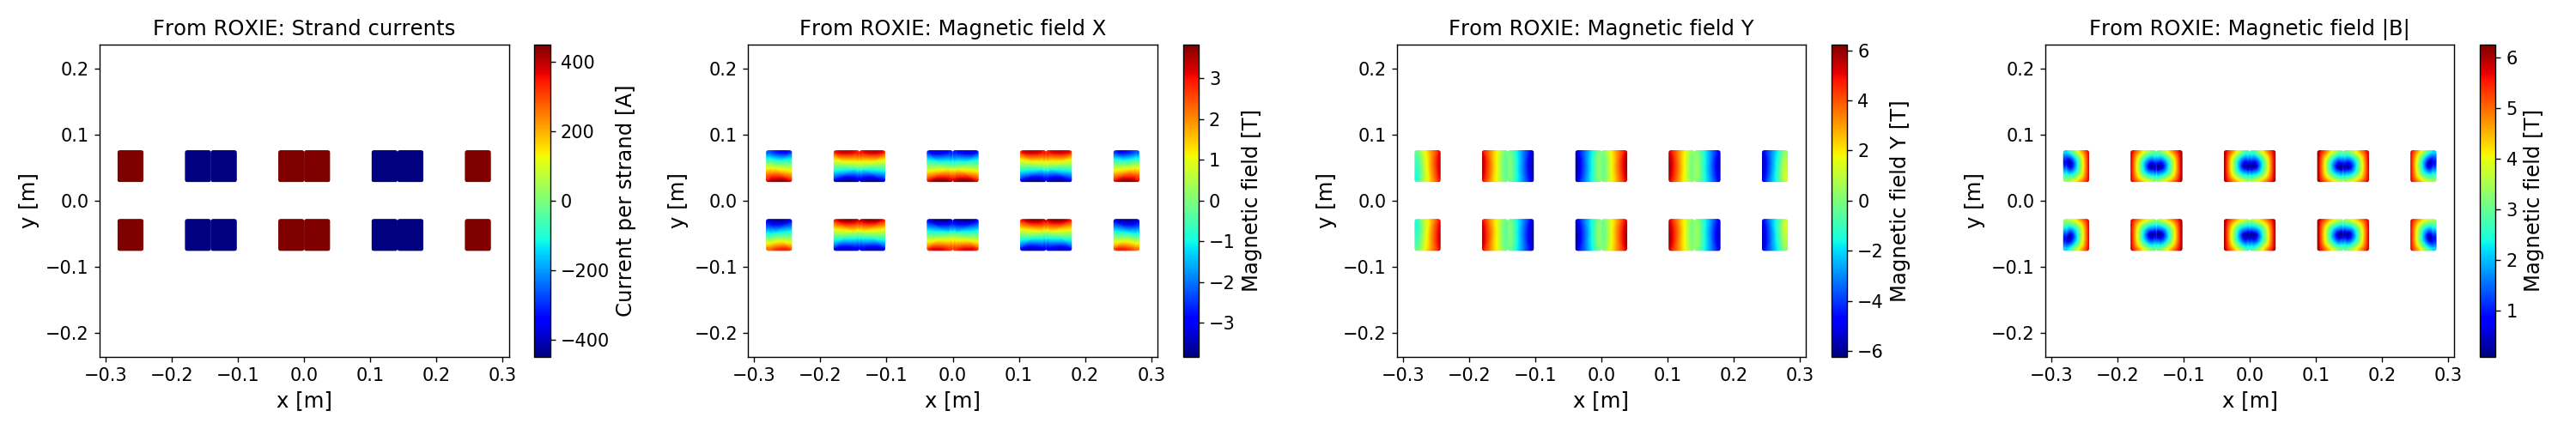

In [5]:
# Acquire data from ROXIE .map2d file
fileName = nameMagnet + '_All_WithIron_WithSelfField.map2d'
headerLines = 1

strandToGroup = np.array([])
strandToHalfTurn = np.array([])
idx = []
x = []
y = []
Bx = []
By = []
Area = []
I = []
fillFactor = []

# Read file
file = open(fileName, "r")
fileContent = file.read()

# Separate rows
fileContentByRow = fileContent.split("\n")

for index in range(len(fileContentByRow)-1):
    if index>headerLines:
        fc = fileContentByRow[index]
        row = fc.split()
        strandToGroup = np.hstack([strandToGroup,int(row[0])])
        strandToHalfTurn = np.hstack([strandToHalfTurn,int(row[1])])
        idx = np.hstack([idx,float(row[2])])
        x = np.hstack([x,float(row[3])/1000]) # in [m]
        y = np.hstack([y,float(row[4])/1000]) # in [m]
        Bx = np.hstack([Bx,float(row[5])])
        By = np.hstack([By,float(row[6])])
        Area = np.hstack([Area,float(row[7])])
        I = np.hstack([I,float(row[8])])
        fillFactor = np.hstack([fillFactor,float(row[9])])
        
[_,c] = np.unique(strandToHalfTurn,return_index=True)
[_,nT] = np.unique(strandToGroup[c],return_counts=True)

nStrandsFieldMap = len(strandToGroup)
print('Total number of strands in the field-map from ROXIE = {}'.format(nStrandsFieldMap))

# Calculate absolute magnetic field
B = []
for i in range(nStrandsFieldMap):
    B = np.hstack([B, (Bx[i]**2+By[i]**2)**.5 ])
print('Peak magnetic field in the field-map from ROXIE = {} T'.format(np.max(B)))

# Plot strand currents and magnetic field
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=I)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Strand currents',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Current per strand [A]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=Bx)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field X',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=By)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field Y',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field Y [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=B)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field |B|',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

In [6]:
minMaxX = [-0.5, 0.5] # to adjust depending on the coil dimensions
minMaxY = [-0.25, 0.25] # to adjust depending on the coil dimensions
nGridPoints=[40, 40]
Bx_map, By_map, B_map, x_map, y_map = definedMagneticCoil.calculateMagneticFieldGrid(minMaxX, minMaxY, nGridPoints)

# Plot current lines
f = plt.figure(figsize=(5, 5))
plt.scatter(xS, yS, s=2, c=iS)
# Plot magnetic field arrows
q = plt.quiver(x_map, y_map, Bx_map, By_map, color='k')
plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Magnetic field lines, not including iron yoke effect', **selectedFont)
plt.set_cmap('jet')
# cbar = plt.colorbar()
# cbar.set_label('Magnetic field [T]', **selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

<IPython.core.display.Javascript object>

(-0.55, 0.55, -0.275, 0.275)

# Manipulate imported strand positions

In [8]:
# Number of strands in each half-turn
nStrands = len(strandToGroup)
polarities = np.sign(I);
nHalfTurns = int(np.max(strandToHalfTurn));
nTurns = int(nHalfTurns/2)
nGroups = int(np.max(strandToGroup));
nS = []
for ht in range(1,nHalfTurns+1):
    #nS =sum(strandToHalfTurn==ht);
    nS = np.hstack([ nS, np.size(np.where(strandToHalfTurn==ht)) ]) # Number of strands in each half-turn
nS = np.int_(nS)

strandToGroup = np.int_(strandToGroup)
strandToHalfTurn = np.int_(strandToHalfTurn)
halfTurnToTurn=np.tile(np.arange(1,nTurns+1),2);

# Average half-turn positions
x_ave = []
y_ave = []
for ht in range(1,nHalfTurns+1):
    x_ave = np.hstack([ x_ave, np.mean( x[np.where(strandToHalfTurn==ht)] )])
    y_ave = np.hstack([ y_ave, np.mean( y[np.where(strandToHalfTurn==ht)] )])

# Average group positions
x_ave_group = []
y_ave_group = []
for g in range(1,nGroups+1):
    x_ave_group = np.hstack([ x_ave_group, np.mean( x[np.where(strandToGroup==g)] )])
    y_ave_group = np.hstack([ y_ave_group, np.mean( y[np.where(strandToGroup==g)] )])
    
print('Total number of strands = ' + str(nStrands))
print('Total number of half-turns = ' + str(nHalfTurns))
print('Total number of turns = ' + str(nTurns))
print('Total number of groups = ' + str(nGroups))


# Plot strand currents and magnetic field
f = plt.figure(figsize=(24,6))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=strandToHalfTurn)
for ht in range(nHalfTurns):
    plt.text(x_ave[ht], y_ave[ht], '{}'.format(ht + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToHalfTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Half-turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=strandToGroup)
for g in range(nGroups):
    plt.text(x_ave_group[g], y_ave_group[g], '{}'.format(g + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x_ave, y_ave, s=2, c=halfTurnToTurn)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('halfTurnToTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Number of strands per half-turn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Number of  strands per cable [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

Total number of strands = 14144
Total number of half-turns = 14144
Total number of turns = 7072
Total number of groups = 544


<IPython.core.display.Javascript object>